# Finch beaks

### EDA of beak depths of Darwin's finches

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [155]:
df1 = pd.read_csv('finch_beaks_1975.csv')
df2 = pd.read_csv('finch_beaks_2012.csv')

In [156]:
df1['year'] = 1975
df2['year'] = 2012

In [157]:
df1.columns = df2.columns

In [158]:
df = pd.concat([df1, df2], sort=False)

In [159]:
df = df[df.species == 'scandens']

In [160]:
df = df[['bdepth', 'year']].reset_index(drop=True)
df.head()

,bdepth,year
0,8.4,1975
1,8.8,1975
2,8.4,1975
3,8.0,1975
4,7.9,1975


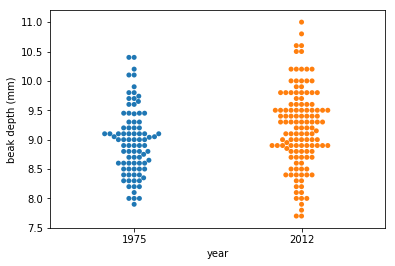

In [161]:
_ = sns.swarmplot(x='year', y='bdepth', data=df)
_ = plt.xlabel('year')
_ = plt.ylabel('beak depth (mm)')
plt.show()

### ECDFs of beak depths

In [162]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

In [164]:
bd_1975 = df1[df1.species == 'scandens'].bdepth.values
bd_2012 = df2[df2.species == 'scandens'].bdepth.values

In [165]:
x_1975, y_1975 = ecdf(bd_1975)
x_2012, y_2012 = ecdf(bd_2012)

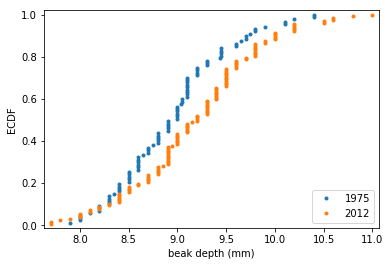

In [166]:
_ = plt.plot(x_1975, y_1975, marker='.', linestyle='none')
_ = plt.plot(x_2012, y_2012, marker='.', linestyle='none')
plt.margins(0.02)
_ = plt.xlabel('beak depth (mm)')
_ = plt.ylabel('ECDF')
_ = plt.legend(('1975', '2012'), loc='lower right')
plt.show()

### Parameter estimates of beak depths

In [167]:
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    return func(np.random.choice(data, size=len(data)))

In [168]:
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

In [169]:
mean_diff = np.mean(bd_2012) - np.mean(bd_1975)

In [170]:
bs_replicates_1975 = draw_bs_reps(bd_1975, np.mean, size=10000)
bs_replicates_2012 = draw_bs_reps(bd_2012, np.mean, size=10000)

In [171]:
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

In [172]:
conf_int = np.percentile(bs_diff_replicates, [2.5, 97.5])

In [173]:
print('difference of means =', mean_diff, 'mm')
print('95% confidence interval =', conf_int, 'mm')

difference of means = 0.22622047244094645 mm
95% confidence interval = [0.06185904 0.38888347] mm


### Hypothesis test: Are beaks deeper in 2012?

The hypothesis we are testing is not that the beak depths come from the same distribution. For that we could use a permutation test. The hypothesis is that the means are equal. To perform this hypothesis test, we need to shift the two data sets so that they have the same mean and then use bootstrap sampling to compute the difference of means.

In [174]:
combined_mean = np.mean(np.concatenate((bd_1975, bd_2012)))

In [175]:
bd_1975_shifted = bd_1975 - np.mean(bd_1975) + combined_mean
bd_2012_shifted = bd_2012 - np.mean(bd_2012) + combined_mean

In [176]:
bs_replicates_1975 = draw_bs_reps(bd_1975_shifted, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(bd_2012_shifted, np.mean, 10000)

In [177]:
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

In [178]:
p = np.sum(bs_diff_replicates >= mean_diff) / len(bs_diff_replicates)
print('p =', p)

p = 0.003


We get a p-value of 0.003, which suggests that there is a statistically significant difference.

### EDA of beak length and depth

In [179]:
bl_1975 = df1[df1.species == 'scandens'].blength.values
bl_2012 = df2[df2.species == 'scandens'].blength.values

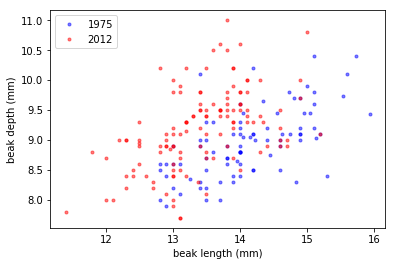

In [181]:
_ = plt.plot(bl_1975, bd_1975, marker='.',
             linestyle='none', color='blue', alpha=0.5)

_ = plt.plot(bl_2012, bd_2012, marker='.',
             linestyle='none', color='red', alpha=0.5)

_ = plt.xlabel('beak length (mm)')
_ = plt.ylabel('beak depth (mm)')
_ = plt.legend(('1975', '2012'), loc='upper left')

plt.show()

### Linear regressions

In [183]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""
    inds = np.arange(len(x))

    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y,1)

    return bs_slope_reps, bs_intercept_reps

In [184]:
slope_1975, intercept_1975 = np.polyfit(bl_1975, bd_1975, 1)
slope_2012, intercept_2012 = np.polyfit(bl_2012, bd_2012, 1)

In [185]:
bs_slope_reps_1975, bs_intercept_reps_1975 = \
        draw_bs_pairs_linreg(bl_1975, bd_1975, size=1000)
bs_slope_reps_2012, bs_intercept_reps_2012 = \
        draw_bs_pairs_linreg(bl_2012, bd_2012, size=1000)

In [186]:
slope_conf_int_1975 = np.percentile(bs_slope_reps_1975, [2.5, 97.5])
slope_conf_int_2012 = np.percentile(bs_slope_reps_2012, [2.5, 97.5])
intercept_conf_int_1975 = np.percentile(bs_intercept_reps_1975, [2.5, 97.5])

intercept_conf_int_2012 = np.percentile(bs_intercept_reps_2012, [2.5, 97.5])

In [187]:
print('1975: slope =', slope_1975,
      'conf int =', slope_conf_int_1975)
print('1975: intercept =', intercept_1975,
      'conf int =', intercept_conf_int_1975)
print('2012: slope =', slope_2012,
      'conf int =', slope_conf_int_2012)
print('2012: intercept =', intercept_2012,
      'conf int =', intercept_conf_int_2012)

1975: slope = 0.4652051691605937 conf int = [0.34249256 0.59262396]
1975: intercept = 2.3908752365842263 conf int = [0.60931686 4.10469411]
2012: slope = 0.462630358835313 conf int = [0.33536157 0.61037565]
2012: intercept = 2.9772474982360198 conf int = [0.99516824 4.71776507]


### Displaying the linear regression results

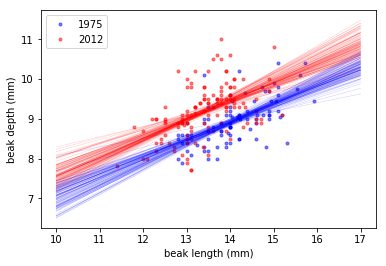

In [189]:
_ = plt.plot(bl_1975, bd_1975, marker='.',
             linestyle='none', color='blue', alpha=0.5)
_ = plt.plot(bl_2012, bd_2012, marker='.',
             linestyle='none', color='red', alpha=0.5)

_ = plt.xlabel('beak length (mm)')
_ = plt.ylabel('beak depth (mm)')
_ = plt.legend(('1975', '2012'), loc='upper left')

x = np.array([10, 17])

for i in range(100):
    plt.plot(x, bs_slope_reps_1975[i]*x+bs_intercept_reps_1975[i],
             linewidth=0.5, alpha=0.2, color='blue')
    plt.plot(x, bs_slope_reps_2012[i]*x+bs_intercept_reps_2012[i],
             linewidth=0.5, alpha=0.2, color='red')

plt.show()

### Beak length to depth ratio

In [190]:
ratio_1975 = bl_1975 / bd_1975
ratio_2012 = bl_2012 / bd_2012

In [191]:
mean_ratio_1975 = np.mean(ratio_1975)
mean_ratio_2012 = np.mean(ratio_2012)

In [192]:
bs_replicates_1975 = draw_bs_reps(ratio_1975, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(ratio_2012, np.mean, 10000)

In [193]:
conf_int_1975 = np.percentile(bs_replicates_1975, [0.5, 99.5])
conf_int_2012 = np.percentile(bs_replicates_2012, [0.5, 99.5])

In [194]:
print('1975: mean ratio =', mean_ratio_1975,
      'conf int =', conf_int_1975)
print('2012: mean ratio =', mean_ratio_2012,
      'conf int =', conf_int_2012)

1975: mean ratio = 1.5788823771858533 conf int = [1.5573049  1.60152228]
2012: mean ratio = 1.4658342276847767 conf int = [1.44384079 1.48771083]


### EDA of heritability

In [198]:
df_her = pd.read_csv('scandens_beak_depth_heredity.csv')

In [201]:
bd_parent_scandens = df_her.mid_parent.values
bd_offspring_scandens = df_her.mid_offspring.values

In [209]:
bd_parent_fortis = np.array([ 10.1  ,   9.55 ,   9.4  ,  10.25 ,  10.125,   9.7  ,   9.05 ,
         7.4  ,   9.   ,   8.65 ,   9.625,   9.9  ,   9.55 ,   9.05 ,
         8.35 ,  10.1  ,  10.1  ,   9.9  ,  10.225,  10.   ,  10.55 ,
        10.45 ,   9.2  ,  10.2  ,   8.95 ,  10.05 ,  10.2  ,   9.5  ,
         9.925,   9.95 ,  10.05 ,   8.75 ,   9.2  ,  10.15 ,   9.8  ,
        10.7  ,  10.5  ,   9.55 ,  10.55 ,  10.475,   8.65 ,  10.7  ,
         9.1  ,   9.4  ,  10.3  ,   9.65 ,   9.5  ,   9.7  ,  10.525,
         9.95 ,  10.1  ,   9.75 ,  10.05 ,   9.9  ,  10.   ,   9.1  ,
         9.45 ,   9.25 ,   9.5  ,  10.   ,  10.525,   9.9  ,  10.4  ,
         8.95 ,   9.4  ,  10.95 ,  10.75 ,  10.1  ,   8.05 ,   9.1  ,
         9.55 ,   9.05 ,  10.2  ,  10.   ,  10.55 ,  10.75 ,   8.175,
         9.7  ,   8.8  ,  10.75 ,   9.3  ,   9.7  ,   9.6  ,   9.75 ,
         9.6  ,  10.45 ,  11.   ,  10.85 ,  10.15 ,  10.35 ,  10.4  ,
         9.95 ,   9.1  ,  10.1  ,   9.85 ,   9.625,   9.475,   9.   ,
         9.25 ,   9.1  ,   9.25 ,   9.2  ,   9.95 ,   8.65 ,   9.8  ,
         9.4  ,   9.   ,   8.55 ,   8.75 ,   9.65 ,   8.95 ,   9.15 ,
         9.85 ,  10.225,   9.825,  10.   ,   9.425,  10.4  ,   9.875,
         8.95 ,   8.9  ,   9.35 ,  10.425,  10.   ,  10.175,   9.875,
         9.875,   9.15 ,   9.45 ,   9.025,   9.7  ,   9.7  ,  10.05 ,
        10.3  ,   9.6  ,  10.   ,   9.8  ,  10.05 ,   8.75 ,  10.55 ,
         9.7  ,  10.   ,   9.85 ,   9.8  ,   9.175,   9.65 ,   9.55 ,
         9.9  ,  11.55 ,  11.3  ,  10.4  ,  10.8  ,   9.8  ,  10.45 ,
        10.   ,  10.75 ,   9.35 ,  10.75 ,   9.175,   9.65 ,   8.8  ,
        10.55 ,  10.675,   9.95 ,   9.55 ,   8.825,   9.7  ,   9.85 ,
         9.8  ,   9.55 ,   9.275,  10.325,   9.15 ,   9.35 ,   9.15 ,
         9.65 ,  10.575,   9.975,   9.55 ,   9.2  ,   9.925,   9.2  ,
         9.3  ,   8.775,   9.325,   9.175,   9.325,   8.975,   9.7  ,
         9.5  ,  10.225,  10.025,   8.2  ,   8.2  ,   9.55 ,   9.05 ,
         9.6  ,   9.6  ,  10.15 ,   9.875,  10.485,  11.485,  10.985,
         9.7  ,   9.65 ,   9.35 ,  10.05 ,  10.1  ,   9.9  ,   8.95 ,
         9.3  ,   9.95 ,   9.45 ,   9.5  ,   8.45 ,   8.8  ,   8.525,
         9.375,  10.2  ,   7.625,   8.375,   9.25 ,   9.4  ,  10.55 ,
         8.9  ,   8.8  ,   9.   ,   8.575,   8.575,   9.6  ,   9.375,
         9.6  ,   9.95 ,   9.6  ,  10.2  ,   9.85 ,   9.625,   9.025,
        10.375,  10.25 ,   9.3  ,   9.5  ,   9.55 ,   8.55 ,   9.05 ,
         9.9  ,   9.8  ,   9.75 ,  10.25 ,   9.1  ,   9.65 ,  10.3  ,
         8.9  ,   9.95 ,   9.5  ,   9.775,   9.425,   7.75 ,   7.55 ,
         9.1  ,   9.6  ,   9.575,   8.95 ,   9.65 ,   9.65 ,   9.65 ,
         9.525,   9.85 ,   9.05 ,   9.3  ,   8.9  ,   9.45 ,  10.   ,
         9.85 ,   9.25 ,  10.1  ,   9.125,   9.65 ,   9.1  ,   8.05 ,
         7.4  ,   8.85 ,   9.075,   9.   ,   9.7  ,   8.7  ,   9.45 ,
         9.7  ,   8.35 ,   8.85 ,   9.7  ,   9.45 ,  10.3  ,  10.   ,
        10.45 ,   9.45 ,   8.5  ,   8.3  ,  10.   ,   9.225,   9.75 ,
         9.15 ,   9.55 ,   9.   ,   9.275,   9.35 ,   8.95 ,   9.875,
         8.45 ,   8.6  ,   9.7  ,   8.55 ,   9.05 ,   9.6  ,   8.65 ,
         9.2  ,   8.95 ,   9.6  ,   9.15 ,   9.4  ,   8.95 ,   9.95 ,
        10.55 ,   9.7  ,   8.85 ,   8.8  ,  10.   ,   9.05 ,   8.2  ,
         8.1  ,   7.25 ,   8.3  ,   9.15 ,   8.6  ,   9.5  ,   8.05 ,
         9.425,   9.3  ,   9.8  ,   9.3  ,   9.85 ,   9.5  ,   8.65 ,
         9.825,   9.   ,  10.45 ,   9.1  ,   9.55 ,   9.05 ,  10.   ,
         9.35 ,   8.375,   8.3  ,   8.8  ,  10.1  ,   9.5  ,   9.75 ,
        10.1  ,   9.575,   9.425,   9.65 ,   8.725,   9.025,   8.5  ,
         8.95 ,   9.3  ,   8.85 ,   8.95 ,   9.8  ,   9.5  ,   8.65 ,
         9.1  ,   9.4  ,   8.475,   9.35 ,   7.95 ,   9.35 ,   8.575,
         9.05 ,   8.175,   9.85 ,   7.85 ,   9.85 ,  10.1  ,   9.35 ,
         8.85 ,   8.75 ,   9.625,   9.25 ,   9.55 ,  10.325,   8.55 ,
         9.675,   9.15 ,   9.   ,   9.65 ,   8.6  ,   8.8  ,   9.   ,
         9.95 ,   8.4  ,   9.35 ,  10.3  ,   9.05 ,   9.975,   9.975,
         8.65 ,   8.725,   8.2  ,   7.85 ,   8.775,   8.5  ,   9.4  ])
bd_offspring_fortis = np.array([ 10.7 ,   9.78,   9.48,   9.6 ,  10.27,   9.5 ,   9.  ,   7.46,
         7.65,   8.63,   9.81,   9.4 ,   9.48,   8.75,   7.6 ,  10.  ,
        10.09,   9.74,   9.64,   8.49,  10.15,  10.28,   9.2 ,  10.01,
         9.03,   9.94,  10.5 ,   9.7 ,  10.02,  10.04,   9.43,   8.1 ,
         9.5 ,   9.9 ,   9.48,  10.18,  10.16,   9.08,  10.39,   9.9 ,
         8.4 ,  10.6 ,   8.75,   9.46,   9.6 ,   9.6 ,   9.95,  10.05,
        10.16,  10.1 ,   9.83,   9.46,   9.7 ,   9.82,  10.34,   8.02,
         9.65,   9.87,   9.  ,  11.14,   9.25,   8.14,  10.23,   8.7 ,
         9.8 ,  10.54,  11.19,   9.85,   8.1 ,   9.3 ,   9.34,   9.19,
         9.52,   9.36,   8.8 ,   8.6 ,   8.  ,   8.5 ,   8.3 ,  10.38,
         8.54,   8.94,  10.  ,   9.76,   9.45,   9.89,  10.9 ,   9.91,
         9.39,   9.86,   9.74,   9.9 ,   9.09,   9.69,  10.24,   8.9 ,
         9.67,   8.93,   9.3 ,   8.67,   9.15,   9.23,   9.59,   9.03,
         9.58,   8.97,   8.57,   8.47,   8.71,   9.21,   9.13,   8.5 ,
         9.58,   9.21,   9.6 ,   9.32,   8.7 ,  10.46,   9.29,   9.24,
         9.45,   9.35,  10.19,   9.91,   9.18,   9.89,   9.6 ,  10.3 ,
         9.45,   8.79,   9.2 ,   8.8 ,   9.69,  10.61,   9.6 ,   9.9 ,
         9.26,  10.2 ,   8.79,   9.28,   8.83,   9.76,  10.2 ,   9.43,
         9.4 ,   9.9 ,   9.5 ,   8.95,   9.98,   9.72,   9.86,  11.1 ,
         9.14,  10.49,   9.75,  10.35,   9.73,   9.83,   8.69,   9.58,
         8.42,   9.25,  10.12,   9.31,   9.99,   8.59,   8.74,   8.79,
         9.6 ,   9.52,   8.93,  10.23,   9.35,   9.35,   9.09,   9.04,
         9.75,  10.5 ,   9.09,   9.05,   9.54,   9.3 ,   9.06,   8.7 ,
         9.32,   8.4 ,   8.67,   8.6 ,   9.53,   9.77,   9.65,   9.43,
         8.35,   8.26,   9.5 ,   8.6 ,   9.57,   9.14,  10.79,   8.91,
         9.93,  10.7 ,   9.3 ,   9.93,   9.51,   9.44,  10.05,  10.13,
         9.24,   8.21,   8.9 ,   9.34,   8.77,   9.4 ,   8.82,   8.83,
         8.6 ,   9.5 ,  10.2 ,   8.09,   9.07,   9.29,   9.1 ,  10.19,
         9.25,   8.98,   9.02,   8.6 ,   8.25,   8.7 ,   9.9 ,   9.65,
         9.45,   9.38,  10.4 ,   9.96,   9.46,   8.26,  10.05,   8.92,
         9.5 ,   9.43,   8.97,   8.44,   8.92,  10.3 ,   8.4 ,   9.37,
         9.91,  10.  ,   9.21,   9.95,   8.84,   9.82,   9.5 ,  10.29,
         8.4 ,   8.31,   9.29,   8.86,   9.4 ,   9.62,   8.62,   8.3 ,
         9.8 ,   8.48,   9.61,   9.5 ,   9.37,   8.74,   9.31,   9.5 ,
         9.49,   9.74,   9.2 ,   9.24,   9.7 ,   9.64,   9.2 ,   7.5 ,
         7.5 ,   8.7 ,   8.31,   9.  ,   9.74,   9.31,  10.5 ,   9.3 ,
         8.12,   9.34,   9.72,   9.  ,   9.65,   9.9 ,  10.  ,  10.1 ,
         8.  ,   9.07,   9.75,   9.33,   8.11,   9.36,   9.74,   9.9 ,
         9.23,   9.7 ,   8.2 ,   9.35,   9.49,   9.34,   8.87,   9.03,
         9.07,   9.43,   8.2 ,   9.19,   9.  ,   9.2 ,   9.06,   9.81,
         8.89,   9.4 ,  10.45,   9.64,   9.03,   8.71,   9.91,   8.33,
         8.2 ,   7.83,   7.14,   8.91,   9.18,   8.8 ,   9.9 ,   7.73,
         9.25,   8.7 ,   9.5 ,   9.3 ,   9.05,  10.18,   8.85,   9.24,
         9.15,   9.98,   8.77,   9.8 ,   8.65,  10.  ,   8.81,   8.01,
         7.9 ,   9.41,  10.18,   9.55,   9.08,   8.4 ,   9.75,   8.9 ,
         9.07,   9.35,   8.9 ,   8.19,   8.65,   9.19,   8.9 ,   9.28,
        10.58,   9.  ,   9.4 ,   8.91,   9.93,  10.  ,   9.37,   7.4 ,
         9.  ,   8.8 ,   9.18,   8.3 ,  10.08,   7.9 ,   9.96,  10.4 ,
         9.65,   8.8 ,   8.65,   9.7 ,   9.23,   9.43,   9.93,   8.47,
         9.55,   9.28,   8.85,   8.9 ,   8.75,   8.63,   9.  ,   9.43,
         8.28,   9.23,  10.4 ,   9.  ,   9.8 ,   9.77,   8.97,   8.37,
         7.7 ,   7.9 ,   9.5 ,   8.2 ,   8.8 ])

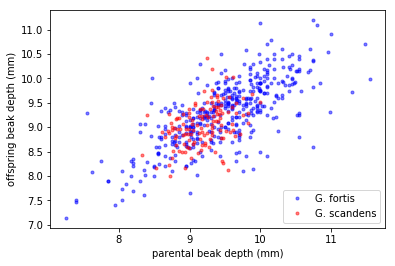

In [210]:
_ = plt.plot(bd_parent_fortis, bd_offspring_fortis,
             marker='.', linestyle='none', color='blue', alpha=0.5)
_ = plt.plot(bd_parent_scandens, bd_offspring_scandens,
             marker='.', linestyle='none', color='red', alpha=0.5)
_ = plt.xlabel('parental beak depth (mm)')
_ = plt.ylabel('offspring beak depth (mm)')
_ = plt.legend(('G. fortis', 'G. scandens'), loc='lower right')
plt.show()

### Correlation of offspring and parental data

In [211]:
def draw_bs_pairs(x, y, func, size=1):
    """Perform pairs bootstrap for a single statistic."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_replicates[i] = func(bs_x, bs_y)

    return bs_replicates

### Pearson correlation of offspring and parental data

In [213]:
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    corr_mat = np.corrcoef(x,y)
    return corr_mat[0,1]

In [214]:
r_scandens = pearson_r(bd_parent_scandens, bd_offspring_scandens)
r_fortis = pearson_r(bd_parent_fortis, bd_offspring_fortis)

In [216]:
bs_replicates_scandens = draw_bs_pairs(bd_parent_scandens, bd_offspring_scandens, pearson_r, 1000)
bs_replicates_fortis = draw_bs_pairs(bd_parent_fortis, bd_offspring_fortis, pearson_r, 1000)

In [217]:
conf_int_scandens = np.percentile(bs_replicates_scandens,[2.5, 97.5])
conf_int_fortis = np.percentile(bs_replicates_fortis,[2.5, 97.5])

In [218]:
print('G. scandens:', r_scandens, conf_int_scandens)
print('G. fortis:', r_fortis, conf_int_fortis)

G. scandens: 0.4117063629401258 [0.27526228 0.53827189]
G. fortis: 0.7283412395518486 [0.6667211  0.78215605]


### Measuring heritability

Remember that the Pearson correlation coefficient is the ratio of the covariance to the geometric mean of the variances of the two data sets. This is a measure of the correlation between parents and offspring, but might not be the best estimate of heritability. If we stop and think, it makes more sense to define heritability as the ratio of the covariance between parent and offspring to the variance of the parents alone. In this exercise, you will estimate the heritability and perform a pairs bootstrap calculation to get the 95% confidence interval.

In [219]:
def heritability(parents, offspring):
    """Compute the heritability from parent and offspring samples."""
    covariance_matrix = np.cov(parents, offspring)
    return covariance_matrix[0,1] / covariance_matrix[0,0]

In [220]:
heritability_scandens = heritability(bd_parent_scandens, bd_offspring_scandens)
heritability_fortis = heritability(bd_parent_fortis, bd_offspring_fortis)

In [221]:
replicates_scandens = draw_bs_pairs(
        bd_parent_scandens, bd_offspring_scandens, heritability, size=1000)
        
replicates_fortis = draw_bs_pairs(
        bd_parent_fortis, bd_offspring_fortis, heritability, size=1000)

In [222]:
conf_int_scandens = np.percentile(replicates_scandens, [2.5, 97.5])
conf_int_fortis = np.percentile(replicates_fortis, [2.5, 97.5])

In [223]:
print('G. scandens:', heritability_scandens, conf_int_scandens)
print('G. fortis:', heritability_fortis, conf_int_fortis)

G. scandens: 0.5485340868685982 [0.35291998 0.73942015]
G. fortis: 0.7229051911438155 [0.64518121 0.79806241]


In [228]:
np.cov(bd_parent_scandens, bd_offspring_scandens)

array([[0.10385436, 0.05696766],
       [0.05696766, 0.18435581]])

### Is beak depth heritable at all in G. scandens?

The heritability of beak depth in G. scandens seems low. It could be that this observed heritability was just achieved by chance and beak depth is actually not really heritable in the species. 

In [229]:
perm_replicates = np.empty(10000)

In [230]:
for i in range(10000):
    # Permute parent beak depths
    bd_parent_permuted = np.random.permutation(bd_parent_scandens)
    perm_replicates[i] = heritability(bd_parent_permuted,
                                      bd_offspring_scandens)

In [231]:
p = np.sum(perm_replicates >= heritability_scandens) / len(perm_replicates)
print('p-val =', p)

p-val = 0.0
